<a href="https://colab.research.google.com/github/John-G-Thomas/Projects-data/blob/master/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 1

In [ ]:
%%capture
import sys
if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
import plotly.express as px
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, cross_val_predict

### Part 2

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/John-G-Thomas/Projects/master/Project24revision.csv')
df.set_index(pd.to_datetime(df['Datetime']), inplace = True)
df = df.drop(columns='Datetime')
print(df.shape)
df.head()

(2970, 12)


,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
Datetime,,,,,,,,,,,,
1761-10-01,10,1761,8.057650,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,7.227
1761-11-01,11,1761,8.074775,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.089
1762-01-01,1,1762,8.106300,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.866
1762-02-01,2,1762,8.099425,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,4.801
1762-03-01,3,1762,8.058075,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.528


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2970 entries, 1761-10-01 to 2010-12-01
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   month                   2970 non-null   int64  
 1   Year                    2970 non-null   int64  
 2   Decade_SMA              2970 non-null   float64
 3   Global_Warming          2970 non-null   int64  
 4   Yearly_SMA_Solid_Fuel   2970 non-null   float64
 5   Yearly_SMA_Gas_Fuel     2970 non-null   float64
 6   Yearly_SMA_Cement       2970 non-null   float64
 7   Yearly_SMA_Gas_Flaring  2970 non-null   float64
 8   Yearly_SMA_Per_Capita   2970 non-null   float64
 9   Yearly_SMA_Liquid_Fuel  2970 non-null   float64
 10  Yearly_SMA_CarbonTotal  2970 non-null   float64
 11  Average_Temps           2970 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 301.6 KB


In [ ]:
df.describe()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,6.518182,1886.620539,8.339950,0.414141,701.358418,191.401684,35.053535,13.615993,0.257497,515.093939,1456.495286,8.370691
std,3.448389,71.651864,0.412514,0.492656,864.692458,398.277173,78.318491,26.648685,0.460562,942.592184,2258.948078,4.299048
min,1.000000,1761.000000,7.220025,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.131000
25%,4.000000,1825.000000,8.054294,0.000000,16.354167,0.000000,0.000000,0.000000,0.000000,0.000000,16.354167,4.357250
50%,7.000000,1887.000000,8.281392,0.000000,278.500000,2.000000,0.000000,0.000000,0.000000,5.000000,285.083333,8.618000
75%,10.000000,1949.000000,8.629850,1.000000,1061.208333,76.729167,14.291667,0.000000,0.000000,362.291667,1439.104167,12.465750
max,12.000000,2010.000000,9.544083,1.000000,3842.000000,1702.000000,450.000000,110.000000,1.330000,3122.000000,9167.000000,15.462000


In [ ]:
#Value counts of all columns 
for col in df.columns:
    print(df[col].value_counts(normalize=True))

11    0.084175
10    0.084175
9     0.083838
3     0.083838
6     0.083838
4     0.083838
12    0.083502
2     0.083502
5     0.083165
8     0.083165
7     0.082155
1     0.080808
Name: month, dtype: float64
2009    0.004040
1928    0.004040
1952    0.004040
1950    0.004040
1948    0.004040
          ...   
1838    0.003704
1773    0.003704
1780    0.003367
1774    0.003030
1761    0.000673
Name: Year, Length: 250, dtype: float64
8.036792    0.000673
8.650258    0.000673
8.492667    0.000673
8.640400    0.000673
8.662267    0.000673
              ...   
8.219817    0.000337
8.565600    0.000337
8.421400    0.000337
8.394367    0.000337
8.273558    0.000337
Name: Decade_SMA, Length: 2960, dtype: float64
0    0.585859
1    0.414141
Name: Global_Warming, dtype: float64
3.000000       0.035354
5.000000       0.035354
4.000000       0.034007
6.000000       0.020539
10.000000      0.016835
                 ...   
1351.000000    0.000337
80.916667      0.000337
317.916667     0.000337
87.666

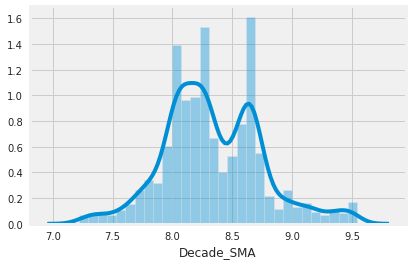

In [ ]:
# Slightly Symetric 
%matplotlib inline
import seaborn as sns
sns.distplot(df['Decade_SMA']);

### Part 3 Baseline

In [ ]:
train = df[0:1800]
val = df[900:1800]
test = df[1800:2970]
print(test.shape)
print(val.shape)
print(train.shape)

(1170, 12)
(900, 12)
(1800, 12)


In [ ]:
# Assign to X, y let try average temps by year instead of sma of decade
target = 'Decade_SMA'
features = df.columns.drop('Decade_SMA')
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
#Check Shapes
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 11)
(1800,)
(900, 11)
(900,)
(1170, 11)
(1170,)


In [ ]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(),
    LinearRegression())
lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.6153901446888066


In [ ]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features).sort_values()

Yearly_SMA_CarbonTotal   -6.543607e+00
Year                     -1.700006e-01
Yearly_SMA_Gas_Fuel      -8.508939e-02
Yearly_SMA_Per_Capita    -1.776357e-15
Yearly_SMA_Cement         5.551115e-17
Yearly_SMA_Gas_Flaring    1.054712e-15
Yearly_SMA_Liquid_Fuel    7.191855e-03
month                     7.216319e-03
Average_Temps             9.496611e-03
Global_Warming            1.534826e-01
Yearly_SMA_Solid_Fuel     6.837875e+00
dtype: float64

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1))
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.9879227229057833


- Lets look at shap

In [ ]:
#Start of carbon emmisions
cutoff = pd.to_datetime('1900-01-01')
train1 = df[df.index < cutoff]
test1  = df[df.index >= cutoff]
# Assign to X, y
features2 = ['Yearly_SMA_CarbonTotal','Yearly_SMA_Per_Capita','month','Global_Warming',
             'Yearly_SMA_Gas_Flaring','Year','Yearly_SMA_Cement','Yearly_SMA_Gas_Fuel',
             'Yearly_SMA_Solid_Fuel','Yearly_SMA_Liquid_Fuel','Average_Temps']
target2 = 'Decade_SMA'
X_train2 = train1[features2]
y_train2 = train1[target2]
X_test2 = test1[features2]
y_test2 = test1[target2]
print(df.shape)
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(2970, 12)
(1638, 11)
(1638,)
(1332, 11)
(1332,)


In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), }
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=4, 
    scoring='neg_mean_absolute_error', 
    verbose=50, 
    return_train_score=True, 
    n_jobs=6, 
    random_state=42)
search.fit(X_test2, y_test2);

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    6.2s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    8.1s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   11.6s
[Paralle

In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 0.19443531040704226


In [ ]:
row = X_test2.iloc[[1300]]
row

,Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps
Datetime,,,,,,,,,,,
2008-05-01,8656.416667,1.288333,5,1,69.25,2008,384.5,1596.583333,3508.583333,3098.083333,12.054


In [ ]:
#Eval Predictor
y_test2.iloc[[1300]]

Datetime
2008-05-01    9.471175
Name: Decade_SMA, dtype: float64

In [ ]:
#What does the model predict for this Temperature
model.predict(row)

array([9.47029693])

In [ ]:
# Why did the model predict this?
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
row = X_train2.iloc[[100]]
row

,Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps
Datetime,,,,,,,,,,,
1770-08-01,3.0,0.0,8,0,0.0,1770,0.0,0.0,3.0,0.0,11.413


In [ ]:
#Eval Predictor
y_train2.iloc[[100]]

Datetime
1770-08-01    8.119533
Name: Decade_SMA, dtype: float64

In [ ]:
#What does the model predict for this Temperature
model.predict(row)

array([8.16058686])

In [ ]:
# Why did the model predict this?
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
def predict(Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,
             Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,
             Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps):
    # Make dataframe from the inputs
    gf = pd.DataFrame(
        data=[[Yearly_SMA_CarbonTotal,Yearly_SMA_Per_Capita,month,Global_Warming,
             Yearly_SMA_Gas_Flaring,Year,Yearly_SMA_Cement,Yearly_SMA_Gas_Fuel,
             Yearly_SMA_Solid_Fuel,Yearly_SMA_Liquid_Fuel,Average_Temps]], 
        columns=['Yearly_SMA_CarbonTotal','Yearly_SMA_Per_Capita','month','Global_Warming',
             'Yearly_SMA_Gas_Flaring','Year','Yearly_SMA_Cement','Yearly_SMA_Gas_Fuel',
             'Yearly_SMA_Solid_Fuel','Yearly_SMA_Liquid_Fuel','Average_Temps'])

    # Get the model's prediction
    pred = model.predict(gf)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(gf)

    # Get series with shap values, feature names, & feature values
    feature_names = gf.columns
    feature_values = gf.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'{pred:,.0f} estimated Decade Average Temparature \n\n'
    #result += f'Starting from baseline of ${explainer.expected_value:,.0f} \n'
    result += shaps.to_string()
    print(result)
    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=gf)
predict(40000, 2, 12,1,10000,2050,10000,10000,10000,5000,10)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


10 estimated Decade Average Temparature 

(Yearly_SMA_CarbonTotal, 40000)    0.179102
(Yearly_SMA_Per_Capita, 2)         0.008539
(month, 12)                        0.000569
(Global_Warming, 1)                0.000217
(Yearly_SMA_Gas_Flaring, 10000)   -0.003402
(Year, 2050)                       0.060627
(Yearly_SMA_Cement, 10000)         0.280933
(Yearly_SMA_Gas_Fuel, 10000)       0.235005
(Yearly_SMA_Solid_Fuel, 10000)     0.073250
(Yearly_SMA_Liquid_Fuel, 5000)     0.031021
(Average_Temps, 10)                0.000283


In [ ]:
test1.tail()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
Datetime,,,,,,,,,,,,
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667,14.768
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000,12.863
2010-10-01,10,2010,9.530717,1,3805.0,1682.50,443.833333,60.166667,1.321667,3104.333333,9095.833333,10.442
2010-11-01,11,2010,9.540508,1,3823.5,1692.25,446.916667,59.583333,1.325833,3109.166667,9131.416667,7.487
2010-12-01,12,2010,9.544083,1,3842.0,1702.00,450.000000,59.000000,1.330000,3114.000000,9167.000000,4.292


### Part 4 Baseline visualized

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

In [ ]:
df2 = pd.DataFrame(index=df.index)
df2['baseline']=df['Average_Temps'].mean()
print(df2.shape)
df2.head()

(2970, 1)


,baseline
Datetime,
1761-10-01,8.370691
1761-11-01,8.370691
1762-01-01,8.370691
1762-02-01,8.370691
1762-03-01,8.370691


In [ ]:
print(df.shape)
df.describe()

(2970, 12)


,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,6.518182,1886.620539,8.339950,0.414141,701.358418,191.401684,35.053535,13.615993,0.257497,515.093939,1456.495286,8.370691
std,3.448389,71.651864,0.412514,0.492656,864.692458,398.277173,78.318491,26.648685,0.460562,942.592184,2258.948078,4.299048
min,1.000000,1761.000000,7.220025,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.131000
25%,4.000000,1825.000000,8.054294,0.000000,16.354167,0.000000,0.000000,0.000000,0.000000,0.000000,16.354167,4.357250
50%,7.000000,1887.000000,8.281392,0.000000,278.500000,2.000000,0.000000,0.000000,0.000000,5.000000,285.083333,8.618000
75%,10.000000,1949.000000,8.629850,1.000000,1061.208333,76.729167,14.291667,0.000000,0.000000,362.291667,1439.104167,12.465750
max,12.000000,2010.000000,9.544083,1.000000,3842.000000,1702.000000,450.000000,110.000000,1.330000,3122.000000,9167.000000,15.462000


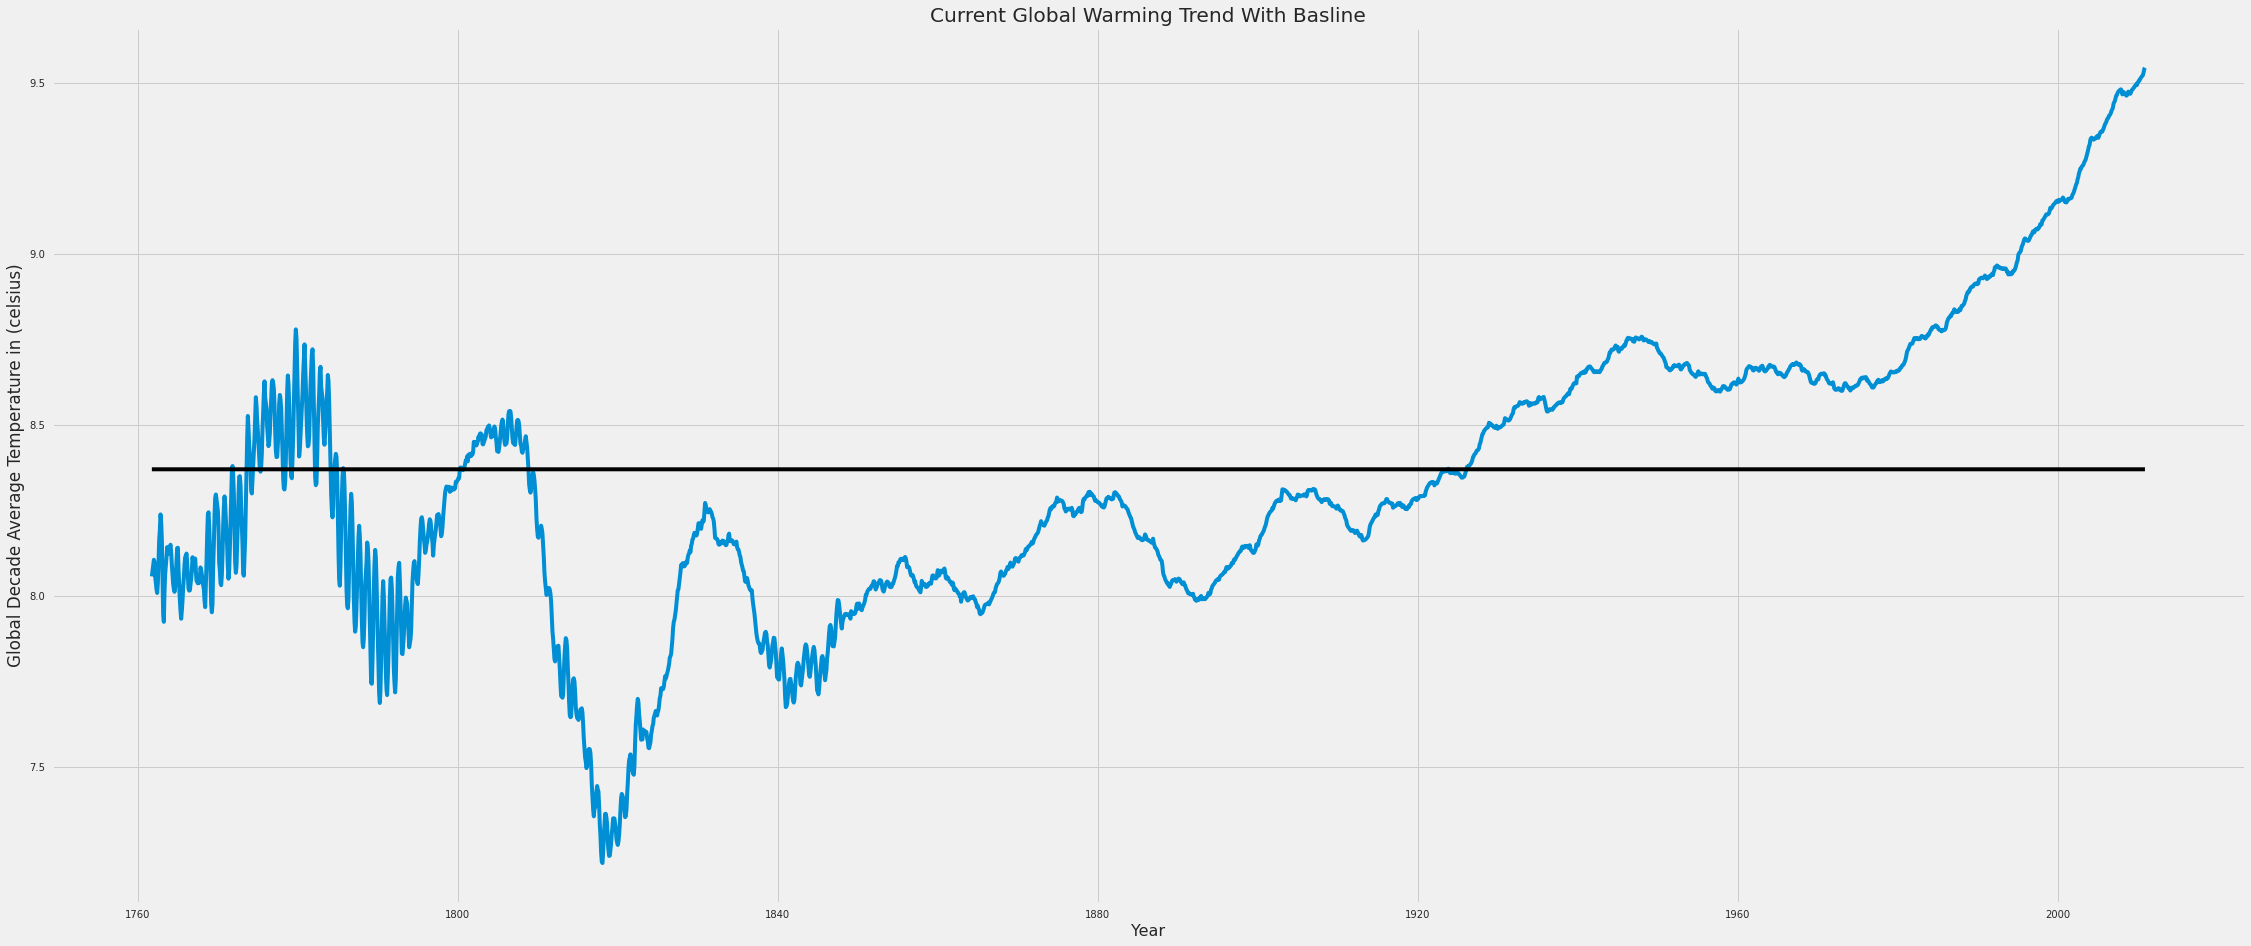

In [ ]:
#Baseline
plt.figure(figsize=(35,15))
plt.title('Current Global Warming Trend With Basline')
plt.plot(df['Decade_SMA'])
plt.plot(df2['baseline'], color='black')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Global Decade Average Temperature in (celsius)');

### Part 5 (LSTM) model

In [ ]:
# Tuesday (LSTM) to predict future global warming temperatures with carbon emmisions and then wihtout carbon emmisions

In [ ]:
df.shape

(2970, 12)

In [ ]:
data = df.filter(['Decade_SMA'])
#Convert dataframe numpy array
dataset=data.values
#Get the number of rows to train the model on 
train_len = math.ceil(len(dataset) *.9)
train_len

2673

In [ ]:
dataset

array([[8.05765   ],
       [8.074775  ],
       [8.1063    ],
       ...,
       [9.53071667],
       [9.54050833],
       [9.54408333]])

In [ ]:
train_len

2673

In [ ]:
#Scale
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.36041479],
       [0.36778337],
       [0.381348  ],
       ...,
       [0.99424857],
       [0.99846174],
       [1.        ]])

In [ ]:
#Training datat set and scaled traiing data set
train_data = scaled_data[0:train_len , :]
#Spilt the data into X_trian and y_train data sets
X_train=[]
y_train = []
for i in range(60, len(train_data)):
  X_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(X_train)
    print(y_train)

[array([0.36041479, 0.36778337, 0.381348  , 0.37838981, 0.36059766,
       0.35143983, 0.34406767, 0.33958198, 0.35143983, 0.37878065,
       0.40586689, 0.41899407, 0.4383711 , 0.42877223, 0.40617885,
       0.35936419, 0.31336348, 0.3033164 , 0.34043896, 0.36362039,
       0.38463607, 0.3973258 , 0.39087157, 0.3890859 , 0.39390864,
       0.39758755, 0.40023379, 0.39036958, 0.37492963, 0.36270246,
       0.3506223 , 0.34473819, 0.34100908, 0.34722665, 0.36392876,
       0.38268905, 0.39610308, 0.39647241, 0.36858297, 0.35037847,
       0.33110543, 0.31695274, 0.30718893, 0.3173149 , 0.33000104,
       0.34732705, 0.35922076, 0.37548541, 0.38447472, 0.38909666,
       0.37761889, 0.36014228, 0.34525453, 0.34258678, 0.34273021,
       0.34984779, 0.35802314, 0.36701245, 0.38454643, 0.37897428])]
[0.3727567079139589]
[array([0.36041479, 0.36778337, 0.381348  , 0.37838981, 0.36059766,
       0.35143983, 0.34406767, 0.33958198, 0.35143983, 0.37878065,
       0.40586689, 0.41899407, 0.4383

In [ ]:
#Convert X_train and y_train to arrays to use in model
X_train, y_train = np.array(X_train), np.array(y_train)
#Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2613, 60, 1)

In [ ]:
#LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# Compile and optimize
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train Model
model.fit(X_train, y_train, batch_size=1,epochs=1)

Epoch 1/1
2613/2613 [==============================] - 90s 34ms/step - loss: 0.0013


In [ ]:
#Test Dataset
test_data = scaled_data[train_len - 60: , :]
X_test = []
y_test = dataset[train_len:, :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])
#Covert to array 
X_test = np.array(X_test)

In [ ]:
#Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Predict Future Global Warming
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred) 

In [ ]:
#Eval LSTM Model - (.0145 degress celius off best model last was .1944) -root mean squared error
rmse = np.sqrt( np.mean(y_pred-y_test)**2)
print(rmse)

0.01453723837085624


In [ ]:
data

,Decade_SMA
Datetime,
1761-10-01,8.057650
1761-11-01,8.074775
1762-01-01,8.106300
1762-02-01,8.099425
1762-03-01,8.058075
...,...
2010-08-01,9.520117
2010-09-01,9.522750
2010-10-01,9.530717


In [ ]:
Val

,Decade_SMA,y_pred
Datetime,,
1998-09-01,9.115733,9.126974
1998-10-01,9.115417,9.129765
1998-11-01,9.116325,9.131946
1998-12-01,9.118875,9.133846
1999-01-01,9.125825,9.135858
...,...,...
2010-08-01,9.520117,9.524595
2010-09-01,9.522750,9.527346
2010-10-01,9.530717,9.530049



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


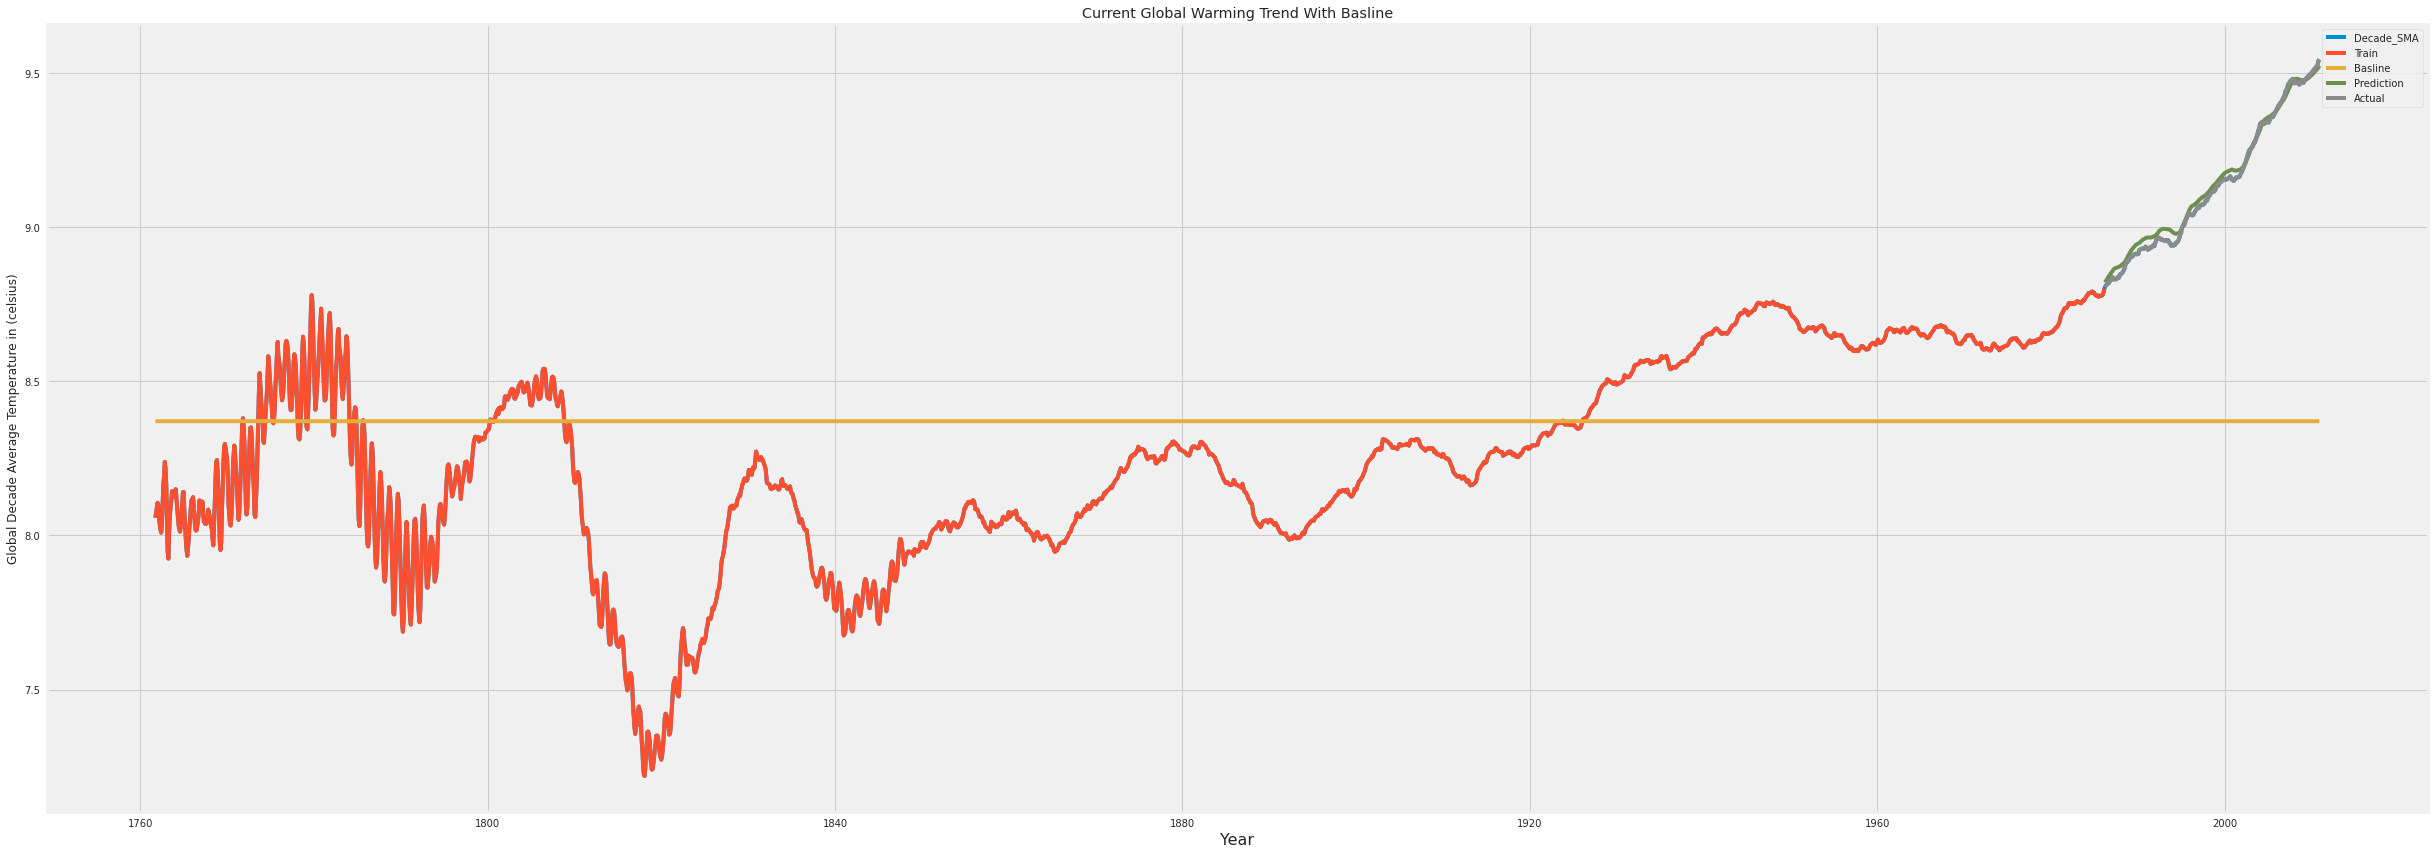

In [ ]:
# Validate 41
Train = data[:train_len]
Val = data[train_len:]
Val['y_pred'] = y_pred
#Plot with baseline
plt.figure(figsize=(38,14.5))
plt.title('Current Global Warming Trend With Basline')
plt.plot(df['Decade_SMA'])
plt.plot(Train)
plt.plot(df2['baseline'])
plt.plot(Val[['y_pred','Decade_SMA']])
plt.legend(['Decade_SMA','Train','Basline','Prediction','Actual'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Global Decade Average Temperature in (celsius)');

In [ ]:
#Predicition until 2050 at current carbon emmision progression
Futuredf = pd.DataFrame(df['Decade_SMA'], index=pd.date_range('2011-1-1', freq='1M', periods=720))
Futuredf

,Decade_SMA
2011-01-31,NaN
2011-02-28,NaN
2011-03-31,NaN
2011-04-30,NaN
2011-05-31,NaN
...,...
2070-08-31,NaN
2070-09-30,NaN
2070-10-31,NaN
2070-11-30,NaN


In [ ]:
Futuredf['Decade_SMA'] = X[['Solid Fuel']].rolling(window=12).mean

,Decade_SMA
2011-01-31,NaN
2011-02-28,NaN
2011-03-31,NaN
2011-04-30,NaN
2011-05-31,NaN
...,...
2070-08-31,NaN
2070-09-30,NaN
2070-10-31,NaN
2070-11-30,NaN


In [ ]:
df

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps,date
Datetime,,,,,,,,,,,,,
1761-10-01,10,1761,8.057650,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000,7.227,1761-10-01
1761-11-01,11,1761,8.074775,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000,5.089,1761-11-01
1762-01-01,1,1762,8.106300,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000,6.866,1762-01-01
1762-02-01,2,1762,8.099425,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000,4.801,1762-02-01
1762-03-01,3,1762,8.058075,0,3.0,0.00,0.000000,0.000000,0.000000,0.000000,3.000000,3.528,1762-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-01,8,2010,9.520117,1,3768.0,1663.00,437.666667,61.333333,1.313333,3094.666667,9024.666667,14.768,2010-08-01
2010-09-01,9,2010,9.522750,1,3786.5,1672.75,440.750000,60.750000,1.317500,3099.500000,9060.250000,12.863,2010-09-01
2010-10-01,10,2010,9.530717,1,3805.0,1682.50,443.833333,60.166667,1.321667,3104.333333,9095.833333,10.442,2010-10-01


### Part 7 Time Series Predicition

In [ ]:
# add imports for timeseries 
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
%matplotlib inline

In [ ]:
Train

,Decade_SMA
Datetime,
1761-10-01,8.057650
1761-11-01,8.074775
1762-01-01,8.106300
1762-02-01,8.099425
1762-03-01,8.058075
...,...
1985-11-01,8.777717
1985-12-01,8.778700
1986-01-01,8.782292


In [ ]:
Val

,Decade_SMA,y_pred
Datetime,,
1986-04-01,8.805417,8.820880
1986-05-01,8.810742,8.824484
1986-06-01,8.813683,8.828517
1986-07-01,8.814833,8.832546
1986-08-01,8.818675,8.836245
...,...,...
2010-08-01,9.520117,9.510136
2010-09-01,9.522750,9.512792
2010-10-01,9.530717,9.515404


In [ ]:
print(df.shape)
df.head()

(2970, 12)


,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
Datetime,,,,,,,,,,,,
1761-10-01,10,1761,8.057650,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,7.227
1761-11-01,11,1761,8.074775,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.089
1762-01-01,1,1762,8.106300,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.866
1762-02-01,2,1762,8.099425,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,4.801
1762-03-01,3,1762,8.058075,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.528


In [ ]:
dftarget = pd.DataFrame(index=df.index)
dftarget['Target']=df['Decade_SMA']
print(dftarget.shape)
dftarget.head()

(2970, 1)


,Target
Datetime,
1761-10-01,8.057650
1761-11-01,8.074775
1762-01-01,8.106300
1762-02-01,8.099425
1762-03-01,8.058075


In [ ]:
y_test2.shape

(297, 1)

In [ ]:
y_train2.shape

(2673, 1)

In [ ]:
# Make arrays and fit
train2, test2 = df[:-297], df[-297:]
y_train2, y_test2 = dftarget[:-297], dftarget[-297:]
scaler = MinMaxScaler()
scaler.fit(train2)
#Target and features
train2 = scaler.transform(train2)
#y_trian2 = scaler.transform(y_trian2)
test2 = scaler.transform(test2)
#y_test2 = scaler.transform(y_test2)
print(train2.shape)
print(y_train2.shape)
print(test2.shape)
print(y_test2.shape)

(2673, 12)
(2673, 1)
(297, 12)
(297, 1)


In [ ]:
#Built Model2
n_input = 100
n_features = 12
generator = TimeseriesGenerator(train2, y_train2, length = n_input,batch_size=6)
model2=Sequential()
model2.add(LSTM(500, activation='relu', input_shape=(n_input, n_features)))
model2.add(Dropout(0.15))
model2.add(Dense(25))
#compile
model2.compile(optimizer='adam', loss='mean_squared_error')
#Fit generator
model2.fit_generator(generator, epochs=297)

Epoch 1/297


KeyError: ignored

### Part 8 ^ didnt work lets try something else Prophet

In [ ]:
import fbprophet as Prophet
import seaborn as sns
import datetime
import time


In [ ]:
df.head()

,month,Year,Decade_SMA,Global_Warming,Yearly_SMA_Solid_Fuel,Yearly_SMA_Gas_Fuel,Yearly_SMA_Cement,Yearly_SMA_Gas_Flaring,Yearly_SMA_Per_Capita,Yearly_SMA_Liquid_Fuel,Yearly_SMA_CarbonTotal,Average_Temps
Datetime,,,,,,,,,,,,
1761-10-01,10,1761,8.057650,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,7.227
1761-11-01,11,1761,8.074775,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.089
1762-01-01,1,1762,8.106300,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.866
1762-02-01,2,1762,8.099425,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,4.801
1762-03-01,3,1762,8.058075,0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.528


In [ ]:
Futuredf = pd.DataFrame(index=df.index)
Futuredf['ds']=df.index
Futuredf['y'] = df['Decade_SMA']
print(Futuredf.shape)
Futuredf.head()

(2970, 2)


,ds,y
Datetime,,
1761-10-01,1761-10-01,8.057650
1761-11-01,1761-11-01,8.074775
1762-01-01,1762-01-01,8.106300
1762-02-01,1762-02-01,8.099425
1762-03-01,1762-03-01,8.058075


In [ ]:
Futuredf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2970 entries, 1761-10-01 to 2010-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2970 non-null   datetime64[ns]
 1   y       2970 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.6 KB


In [ ]:
prophet_basic = Prophet()
prophet_basic.fit(Futuredf)

TypeError: ignored

In [ ]:
future = prophet_basics.make_featur_dataframe